## Read the Resampled Dataset
The first step in model development is to read the resampled dataset. The resampled dataset is constructed with the condensed nearest neighbor approach rather the randomly undersampling the majority class upto the threshold value determined using the estimated false positive and false negative costs.

In [3]:
import pandas as pd
fp = "../data/sba_training_resampled.csv"
df = pd.read_csv(fp)

In [4]:
preds = df.columns.tolist()
preds.remove("LoanStatus")

In [5]:
X = df[preds]
y = df["LoanStatus"]

## Model Development
For the purposes of illustration, the decision tree classifier is used. Decision trees are easy to interpret and are one of the popular choices for interpretable models in many application domains. We use a Grid search to estimate the best value of the _depth_ hyper-parameter and also the _criterion_ to split the nodes ("gini" and "entropy"). The best tree model from the grid search procedure is used for model development.

In [6]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
    # decision tree model
dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=5)
    #fit model to data
dtree_gscv.fit(X, y)
dtree_gscv.best_params_

{'criterion': 'gini', 'max_depth': 3}

In [7]:
dtree_gscv.best_score_

0.8898113207547169

## Model selection
Model selection is based on cross validation. We hold out a test set separately to get an estimate of the out of sample performance of the model

In [8]:
model = dtree_gscv.best_estimator_

In [9]:
fp_test = "../data/sba_test_dataset.csv"
df_test = pd.read_csv(fp)
Xt = df_test[preds]
yt = df_test["LoanStatus"]

In [10]:
yp = model.predict(Xt)

## Evaluation Metric
Because of the class imbalance (in the test set, note that the resampling fixed the imbalance in the training set), we use the balanced accuracy score rather than accuracy score to evaluate the performance on the hold out test set. See [this article](https://stephenallwright.com/balanced-accuracy/) for example to more details or an explaination in simple terms about the metric.

In [11]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(yt, yp)

0.8887195121951219

In [12]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(yt, yp))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.78      1.00      0.87      0.88      0.76      1312
        1.0       0.82      1.00      0.78      0.90      0.88      0.79      1338

avg / total       0.91      0.89      0.89      0.89      0.88      0.78      2650



## Evaluation with threshold probability
Rather than use the model's (developed from the resampled dataset) default threshold of 0.5 to class a positive class, we can use the threshold based on the costs. In this example, it turns out that the threshold is pretty close to 0.5 and there are is no change in balanced accuracy between using the default threshold and the cost based threshold.

In [13]:
c_10 = 266977.95 # false_positive_cost 
c_01 = 280291.01 # false_negative_ cost
pstar = c_01/(c_10 + c_01)
print('Threshold value of probability is : {:.{prec}f}'.format(pstar, prec=2))

Threshold value of probability is : 0.51


In [14]:
df_test["p_1"] = model.predict_proba(Xt)[:,1]

In [15]:
df_test["yp_opt"] = df_test["p_1"].apply(lambda x: 1 if x > pstar else 0)

In [16]:
print(classification_report_imbalanced(yt, df_test["yp_opt"]))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.78      1.00      0.87      0.88      0.76      1312
        1.0       0.82      1.00      0.78      0.90      0.88      0.79      1338

avg / total       0.91      0.89      0.89      0.89      0.88      0.78      2650



## Get the feature importance
Obtain the feature importance from the model in normalized form and then plot the feature importance in descending order of magnitude (most important features listed first).

In [17]:
feat_importance = model.tree_.compute_feature_importances(normalize=True)
print("feat importance = " + str(feat_importance))

feat importance = [0.         0.         0.0082509  0.         0.         0.06322006
 0.92852904]


In [18]:
[(preds[x], feat_importance[x]) for x in np.argsort(-feat_importance)]

[('D_BorrZip_ND', 0.9285290389654883),
 ('D_BankZip_ND', 0.063220063094055),
 ('TermInMonths', 0.008250897940456716),
 ('JobsSupported', 0.0),
 ('InitialInterestRate', 0.0),
 ('GrossApproval', 0.0),
 ('SBAGuaranteedApproval', 0.0)]

## Notes
No surprise, the borrower zip is the most important attribute

In [19]:
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline

## Reliablity Plot (Probability Calibration)
A plot of the probability predicted by the classifier versus actual probablities on the test set (obtained by binning the predicted probability and then counting the predicted and actual labels of the points in each bin). A review shows that the probability estimated by the model is reliable and we don't need to calibrate the probability.

{'pred_probs': array([0.        , 0.77284264, 0.86579572]),
 'emp_probs': array([0.        , 0.77284264, 0.86579572]),
 'bin_counts': array([1020.,  788.,  842.])}

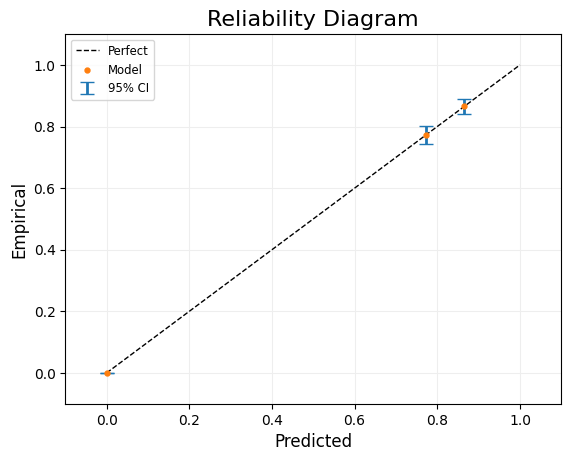

In [22]:
mli.plot_reliability_diagram(yt, df_test["p_1"], marker='.')

In [26]:
??mli.plot_reliability_diagram

Signature:
mli.plot_reliability_diagram(
    y,
    x,
    bins=array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
    show_baseline=True,
    baseline_color='black',
    baseline_width=1,
    error_bars=True,
    error_bar_color='C0',
    error_bar_alpha=0.05,
    error_bar_width=2,
    ci_ref='axis',
    marker='.',
    marker_color='C1',
    marker_edge_color='C1',
    marker_size=50,
    scaling='none',
    scaling_eps=0.0001,
    scaling_base=10,
    cap_width=1,
    cap_size=5,
    show_histogram=False,
    bin_color='C0',
    bin_edge_color='black',
    ax1_x_title='Predicted',
    ax1_y_title='Empirical',
    ax2_x_title='Predicted Scores',
    ax2_y_title='Count',
    ax_title_weight='normal',
    ax_title_size=12,
    title_size=16,
    title_weight='normal',
    reliability_title='Reliability Diagram',
    histogram_title='Probability Distribution',
    layout_pad=3.0,
    legend_names